## Building a Jupyter + MySQL + Redis Data Pipeline

This requires running the **Full Stack** which uses the https://github.com/jay-johnson/sci-pype/blob/master/full-stack-compose.yml to deploy three docker containers on the same host:

- MySQL (https://hub.docker.com/r/jayjohnson/schemaprototyping/)
- Jupyter (https://hub.docker.com/r/jayjohnson/jupyter/)
- Redis (https://hub.docker.com/r/jayjohnson/redis-single-node/)

![Sci-Pype](https://jaypjohnson.com/_images/image_2016-08-01_building-a-data-science-pipeline.png "Jupyter + MySQL + Redis Data Pipeline")

### Overview

Here is how it works:

1. Extract and Transform the IBM pricing data
    - Extract the IBM stock data from the MySQL dataset and store it as a csv inside the **/opt/work/data/src/ibm.csv** file
1. Load the IBM pricing data with Pandas
1. Plot the pricing data with Matlab
1. Publish the Pandas Dataframe as JSON to Redis
1. Retrieve the Pandas Dataframe from Redis
1. Test the cached pricing data exists outside the container with:
   ```
   $ ./redis.sh 
   SSH-ing into Docker image(redis-server)
   [root@redis-server container]# redis-cli -h localhost -p 6000
   localhost:6000> LRANGE LATEST_IBM_DAILY_STICKS 0 0
   1) "(dp0\nS'Data'\np1\nS'{\"Date\":{\"49\":971136000000,\"48\":971049600000,\"47\":970790400000,\"46\":970704000000,\"45\":970617600000,\"44\":970531200000,\"43\":970444800000,\"42\":970185600000,\"41\":970099200000,\"40\":970012800000,\"39\":969926400000,\"38\":969

    ... removed for docs ... 
    
   localhost:6000> exit
   [root@redis-server container]# exit
   exit
   $
   ```
   

Extracting Stock(IBM) DaysBack(10000) Output(/opt/work/data/src/ibm.csv) Dates[1989-10-20 04:38:04.966818 - 2017-03-07 04:38:04.966818]
Stock(IBM) TotalRecords(50)
Percent(0.00) Rec(0/50)
Done Writing(50) Output(/opt/work/data/src/ibm.csv)
Success File exists: /opt/work/data/src/ibm.csv

--------------------------------------------

Processing IBM data stored in CSV(/opt/work/data/src/ibm.csv)
Reading CSV with Pandas

Data Head with Sticks(50)
         Date    Open    High     Low   Close    Volume
49 2000-10-10  116.62  117.12  112.44  114.88   5596300
48 2000-10-09  115.94  119.38  114.31  117.94   4898000
47 2000-10-06  114.00  116.12  112.75  116.00   6102800
46 2000-10-05  113.81  114.56  111.56  113.19   5511500
45 2000-10-04  110.38  114.88  108.56  114.38  11644600

-------------------------------------------------
Creating Ticker(IBM) Plot by Close Prices

Plotting the Data X-axis(Date) Y-axis(Close)

-------------------------------------------------

Converting to JSON
Cachin

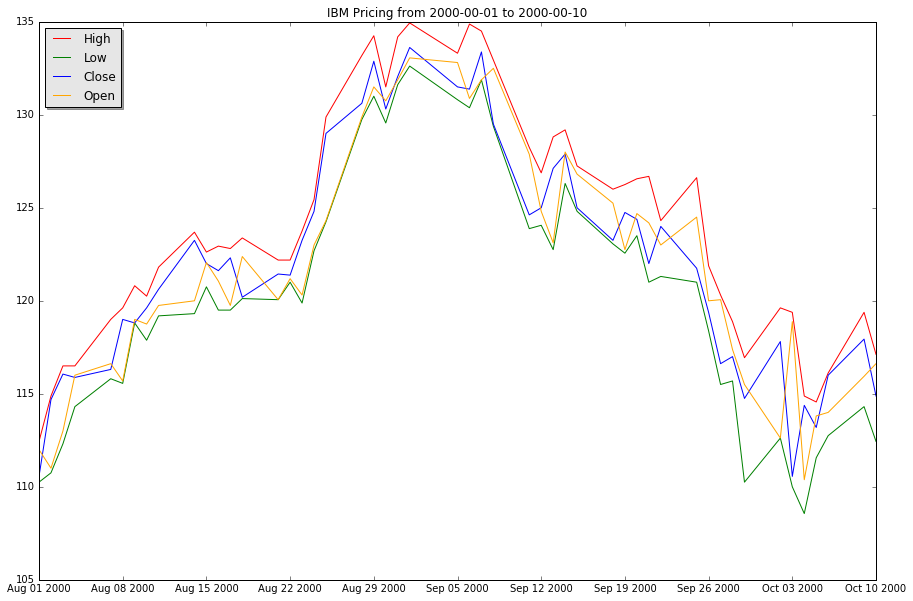

In [1]:
import os, sys, json, datetime

sys.path.insert(0, os.getenv('ENV_PYTHON_SRC_DIR', '/opt/work/src'))

from pycore import PyCore

# shell printing allows just lg('show log')
from   common.shellprinting import *
from   logger.logger        import Logger

data_dir        = os.getenv('ENV_DATA_SRC_DIR', '/opt/work/data/src')


ticker          = 'IBM'
days_back       = 10000 # all sticks in the db
output_file     = str(data_dir) + '/' + ticker.lower() + '.csv'

def db_extract_stock_records(core, ticker, days_back, output_file):

    try:

        # Most of the SQLAlchemy methods have required some form of these lines
        # So I added all of them here for making it easier to just include them all:
        from sqlalchemy import Column, Integer, String, ForeignKey, Table, create_engine, MetaData, Date, DateTime, Float, Boolean, cast, or_, and_, asc, desc
        from sqlalchemy.orm import relationship, backref, scoped_session, sessionmaker, relation
        from sqlalchemy.ext.declarative import declarative_base

        # import that custom schema files
        from databases.schema.db_schema_stocks import BT_Stocks

        # Determine the dates based off the parameters:
        right_now       = datetime.datetime.now()
        end_date_str    = right_now
        start_date_str  = right_now - datetime.timedelta(days=days_back)

        lg('Extracting Stock(' + str(ticker) + ') DaysBack(' + str(days_back) + ') Output(' + str(output_file) + ') Dates[' + str(start_date_str) + ' - ' + str(end_date_str) + ']', 6)
        
        # Extract the records that match by the Symbol and are within the date range
        # then order them by descending order:
        db_recs = core.m_dbs['STOCKS'].m_session.query(BT_Stocks).filter(and_( \
                                        BT_Stocks.Symbol == str(ticker).upper(), \
                                        (cast(BT_Stocks.Date, DateTime) >= start_date_str), \
                                    (end_date_str >= cast(BT_Stocks.Date, DateTime)) )) \
                                    .order_by(desc(BT_Stocks.id)) \
                                    .limit(50) \
                                    .all()

        if os.path.exists(output_file):
            os.system('rm -f ' + str(output_file))
        # end of if there is something to remove before creating a new version

        lg('Stock(' + str(ticker) + ') TotalRecords(' + str(len(db_recs)) + ')', 6)
        with open(output_file, 'w') as csv_file:

            csv_file.write('Date,Open,High,Low,Close,Volume\n')
            total_recs      = len(db_recs)
            for idx,rec in enumerate(db_recs):

                if idx % 100 == 0:
                    lg('Percent(' + str(core.get_percent_done(idx, total_recs)) + ') Rec(' + str(idx) + '/' + str(total_recs) + ')', 6)
                # end of if need to print records
                    
                # Convert to strings:
                date_str    = rec.Date.strftime('%d-%b-%y')
                open_str    = '%0.2f' % float(rec.Open)
                high_str    = '%0.2f' % float(rec.High)
                low_str     = '%0.2f' % float(rec.Low)
                close_str   = '%0.2f' % float(rec.Close)
                volume_str  = str(int(rec.Volume))

                # build the csv line string
                line_str    = str(date_str) \
                                + ',' + str(open_str) \
                                + ',' + str(high_str) \
                                + ',' + str(low_str) \
                                + ',' + str(close_str) \
                                + ',' + str(volume_str)
                               
                # Write the csv line to the file with a newline character:
                csv_file.write(line_str + '\n')
                
            # end of all records
            lg('Done Writing(' + str(total_recs) + ') Output(' + str(output_file) + ')', 6)
        # end of writing output file

    except Exception as e:
        lg('ERROR: Failed to extract Stock(' + str(ticker) + ') Records with Ex(' + str(e) + ')', 0)
    # end of try/ex

# end of db_extract_stock_records

# Specify to connect the core to the redis server
# running inside the container and listening on port 6000
os.environ['ENV_DEPLOYMENT_TYPE'] = 'Test'

# Initialize the core that will connect to the other containers
core = PyCore()

# Extract and transform the records into a csv file
db_extract_stock_records(core, ticker, days_back, output_file)

if os.path.exists(output_file):
    lg('Success File exists: ' + str(output_file), 5)
    
    lg('')
    lg('--------------------------------------------', 2)
    lg('')

    csv_file = output_file
    lg('Processing ' + str(ticker) + ' data stored in CSV(' + str(csv_file) + ')', 6)
    
    # Start loading the data
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd
    
    %matplotlib inline
    import numpy as np
    lg('Reading CSV with Pandas')
    # handle date formats and the special tab-character on the header row with utf-8-sig
    dateparse = lambda x: pd.datetime.strptime(x, '%d-%b-%y')
    data = pd.read_csv(csv_file, parse_dates=[0], date_parser=dateparse, encoding='utf-8-sig') \
                 .sort_values(by='Date', ascending=False)
    
    lg('')
    lg('Data Head with Sticks(' + str(len(data)) + ')', 1)
    print data.head()
    
    lg('', 6)
    lg('-------------------------------------------------', 2)
    lg('Creating Ticker(' + str(ticker) + ') Plot by Close Prices', 2)
    lg('', 6)
    
    # Set the size of the figure
    plt.rcParams['figure.figsize'] = (15.0, 10.0)
    
    all_dates   = data.columns.values[0]
    all_highs   = data.columns.values[2]
    all_closes  = data.columns.values[4]
    lg('Plotting the Data X-axis(' + str(all_dates) + ') Y-axis(' + str(all_closes) + ')', 5)

    # Plot lines by referencing the dataframe keys 
    fig, ax    = plt.subplots()
    max_cell   = len(data['Date']) - 1
    start_date = str(data['Date'][0].strftime('%Y-%M-%d'))
    end_date   = str(data['Date'][max_cell].strftime('%Y-%M-%d'))
    ax.set_title(ticker + ' Pricing from ' + str(start_date) + ' to ' + str(end_date))
    
    plt.plot(data['Date'], data['High'],  color='red',    label='High')
    plt.plot(data['Date'], data['Low'],   color='green',  label='Low')
    plt.plot(data['Date'], data['Close'], color='blue',   label='Close')
    plt.plot(data['Date'], data['Open'],  color='orange', label='Open')
    
    # Now add the legend with some customizations.
    legend = ax.legend(loc='upper left', shadow=True, bbox_to_anchor=(0, 1.0))

    # The frame is matplotlib.patches.Rectangle instance surrounding the legend.
    frame = legend.get_frame()
    frame.set_facecolor('0.90')
    
    lg('', 6)
    lg('-------------------------------------------------', 2)
    lg('', 6)
    
    # connect the core to the redis cache if it exists
    cache_key = 'LATEST_' + ticker + '_DAILY_STICKS'
    lg('Converting to JSON')
    json_data_rec = data.to_json()
    cache_this    = {
                      'Ticker' : ticker,
                      'Data'   : json_data_rec
                  }
    lg('Caching the Ticker(' + ticker + ') Candlesticks')
    results  = core.purge_and_cache_records_in_redis(core.m_rds['CACHE'], cache_key, cache_this)

    lg('')
    lg('-------------------------------------------------', 2)
    lg('')
    
    # confirm we can retrieve the cached data without removing it from the cache:
    lg('Retrieving Cached Ticker(' + ticker + ') Candlesticks')
    cache_record  = core.get_cache_from_redis(core.m_rds['CACHE'], cache_key)
    lg('')

    # the core will return a dictionary where the 'Status' == 'SUCCESS' when it was able to pull records
    # records out of redis. After checking the 'Status', the dataset is stored under the 'Record' key.
    if cache_record['Status'] == 'SUCCESS':
        rec        = cache_record['Record']
        cache_data = rec['Data']
        sticks     = pd.read_json(cache_data).sort_values(by='Date', ascending=False)
        lg(' - SUCCESS found cached records for Ticker(' + str(rec['Ticker']) + ')', 5)
        lg('')
        lg(' - Data Head with Sticks(' + str(len(sticks)) + ')')
        print sticks.head()
    else:
        lg('ERROR: Failed to retreive Cached Candlesticks', 0)
    # end of retrieving cache example

    lg('')
    
else:
    lg('Failed to Extract File', 0)
# did the extraction work or not
